# 5.4 SAGAN 작성

- Self-Attention GAN 네트워크를 구현하고 학습합니다.


# 5.4 학습 목표

1.	SAGAN을 구현할 수 있다


# 사전 준비
도서의 지시에 따라, 이 장에서 사용하는 데이터를 준비합니다

In [ ]:
# 패키지 import
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

In [ ]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# Self-Attention 모듈 구현

In [ ]:
class Self_Attention(nn.Module):
    """Self-Attention의 Layer"""

    def __init__(self, in_dim):
        super(Self_Attention, self).__init__()

        # 1×1의 합성곱 층에 의한 pointwise convolution를 준비
        self.query_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(
            in_channels=in_dim, out_channels=in_dim, kernel_size=1)

        # Attention Map 작성시의 규격화의 소프트맥스
        self.softmax = nn.Softmax(dim=-2)

        # 원래 입력 x와 Self-Attention Map인 o를 더할 때의 계수
        # output = x +gamma*o
        # 처음에는 gamma=0으로 학습시킨다
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):

        # 입력 변수
        X = x

        # 합성곱한 뒤, 크기를 변형시킨다. B,C',W,H→B,C',N으로
        proj_query = self.query_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # 크기: B,C',N
        proj_query = proj_query.permute(0, 2, 1)  # 전치 조작
        proj_key = self.key_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # 크기: B,C',N

        # 곱셈
        S = torch.bmm(proj_query, proj_key)  # bmm은 배치별 행렬곱입니다

        # 규격화
        attention_map_T = self.softmax(S)  # i행 방향의 합을 1로 하는 소프트맥스 함수
        attention_map = attention_map_T.permute(0, 2, 1)  # 전치한다

        # Self-Attention Map을 계산한다
        proj_value = self.value_conv(X).view(
            X.shape[0], -1, X.shape[2]*X.shape[3])  # 크기: B,C,N
        o = torch.bmm(proj_value, attention_map.permute(
            0, 2, 1))  # Attention Map을 전치하여 곱함

        # Self-Attention Map o의 텐서 크기를 X로 준비하여 출력으로 한다
        o = o.view(X.shape[0], X.shape[1], X.shape[2], X.shape[3])
        out = x+self.gamma*o

        return out, attention_map


# Generator 구현

In [ ]:
class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            # Spectral Normalization을 추가
            nn.utils.spectral_norm(nn.ConvTranspose2d(z_dim, image_size * 8,
                                                      kernel_size=4, stride=1)),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            # Spectral Normalization을 추가
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 8, image_size * 4,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            # Spectral Normalization을 추가
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 4, image_size * 2,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        # Self-Attention층을 추가
        self.self_attntion1 = Self_Attention(in_dim=image_size * 2)

        self.layer4 = nn.Sequential(
            # Spectral Normalization을 추가
            nn.utils.spectral_norm(nn.ConvTranspose2d(image_size * 2, image_size,
                                                      kernel_size=4, stride=2, padding=1)),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        # Self-Attention층을 추가
        self.self_attntion2 = Self_Attention(in_dim=image_size)

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4,
                               stride=2, padding=1),
            nn.Tanh())
        # 주의: 흑백 화상이므로 출력 채널은 하나 뿐임


    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attntion1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attntion2(out)
        out = self.last(out)

        return out, attention_map1, attention_map2


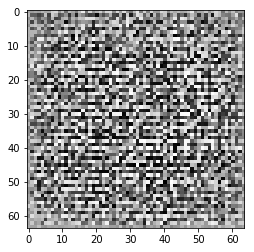

In [ ]:
# 동작 확인
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

# 난수 입력
input_z = torch.randn(1, 20)

# 텐서 크기를 (1, 20, 1, 1)으로 변형
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 가짜 화상을 출력
fake_images, attention_map1, attention_map2 = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()


# Discriminator 구현

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            # Spectral Normalization을 추가
            nn.utils.spectral_norm(nn.Conv2d(1, image_size, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))
        # 주의: 흑백 화상이므로 출력 채널은 하나 뿐임

        self.layer2 = nn.Sequential(
            # Spectral Normalization을 추가
            nn.utils.spectral_norm(nn.Conv2d(image_size, image_size*2, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            # Spectral Normalization을 추가
            nn.utils.spectral_norm(nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))

        # Self-Attention층을 추가
        self.self_attntion1 = Self_Attention(in_dim=image_size*4)

        self.layer4 = nn.Sequential(
            # Spectral Normalization을 추가
            nn.utils.spectral_norm(nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                                             stride=2, padding=1)),
            nn.LeakyReLU(0.1, inplace=True))

        # Self-Attention층을 추가
        self.self_attntion2 = Self_Attention(in_dim=image_size*8)

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out, attention_map1 = self.self_attntion1(out)
        out = self.layer4(out)
        out, attention_map2 = self.self_attntion2(out)
        out = self.last(out)

        return out, attention_map1, attention_map2


In [ ]:
# 동작 확인
D = Discriminator(z_dim=20, image_size=64)

# 가짜 화상 생성
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images, _, _ = G(input_z)

# 가짜 화상을 D에 입력
d_out, attention_map1, attention_map2 = D(fake_images)

# 출력 d_out에 Sigmoid를 곱해 0에서 1로 변환
print(nn.Sigmoid()(d_out))


tensor([[[[0.4980]]]], grad_fn=<SigmoidBackward>)


# DataLoader 작성

In [ ]:
def make_datapath_list():
    """학습 및 검증 화상 데이터와 어노테이션 데이터의 파일 경로 리스트를 작성한다. """

    train_img_list = list()  # 화상 파일 경로를 저장

    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


In [ ]:
class ImageTransform():
    """화상의 전처리 클래스"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)


In [ ]:
class GAN_Img_Dataset(data.Dataset):
    """화상의 Dataset 클래스. PyTorch의 Dataset 클래스를 상속"""

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''화상 매수를 반환한다'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''전처리한 화상의 Tensor 형식 데이터 취득'''

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [높이][폭]흑백

        # 화상 전처리
        img_transformed = self.transform(img)

        return img_transformed


In [ ]:
# DataLoader 작성과 동작 확인

# 파일 리스트를 작성
train_img_list=make_datapath_list()

# Dataset 작성
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(
    file_list=train_img_list, transform=ImageTransform(mean, std))

# DataLoader 작성
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

# 동작 확인
batch_iterator = iter(train_dataloader)  # 반복자로 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼낸다
print(imges.size())  # torch.Size([64, 1, 64, 64])


torch.Size([64, 1, 64, 64])


# 학습시킨다

In [ ]:
# 모델을 학습시키는 함수를 작성
def train_model(G, D, dataloader, num_epochs):

    # GPU가 사용 가능한지 확인
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("사용 장치: ", device)

    # 최적화 기법 설정
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 오차함수 정의 → hinge version of the adversarial loss로 변경
    # criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # 파라미터를 하드코딩
    z_dim = 20
    mini_batch_size = 64

    # 네트워크를 GPU로
    G.to(device)
    D.to(device)

    G.train()  # 모델을 훈련 모드로
    D.train()  # 모델을 훈련 모드로

    # 네트워크가 어느 정도 고정되면, 고속화시킨다
    torch.backends.cudnn.benchmark = True

    # 화상의 매수
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # 반복 카운터 설정
    iteration = 1
    logs = []

    # epoch 루프
    for epoch in range(num_epochs):

        # 개시 시간을 저장
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epoch의 손실합
        epoch_d_loss = 0.0  # epoch의 손실합

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('(train)')

        # 데이터 로더에서 minibatch씩 꺼내는 루프
        for imges in dataloader:

            # --------------------
            # 1. Discriminator 학습
            # --------------------
            # 미니 배치 크기가 1이면, 배치 노멀라이제이션에서 에러가 발생하므로 피한다
            if imges.size()[0] == 1:
                continue

            # GPU가 사용 가능하면 GPU로 데이터를 보낸다
            imges = imges.to(device)

            # 정답 라벨과 가짜 라벨 작성
            # epoch의 마지막 반복은 미니 배치 수가 줄어든다
            mini_batch_size = imges.size()[0]
            #label_real = torch.full((mini_batch_size,), 1).to(device)
            #label_fake = torch.full((mini_batch_size,), 0).to(device)

            # 진짜 화상을 판정
            d_out_real, _, _ = D(imges)

            # 가짜 화상을 생성해 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake, _, _ = D(fake_images)

            # 오차를 계산→hinge version of the adversarial loss로 변경
            # d_loss_real = criterion(d_out_real.view(-1), label_real)
            # d_loss_fake = criterion(d_out_fake.view(-1), label_fake)

            d_loss_real = torch.nn.ReLU()(1.0 - d_out_real).mean()
            # 오차 d_out_real이 1이상에서 오차 0이 된다. d_out_real>1에서,
            # 1.0 - d_out_real가 음수이면 ReLU로 0으로 한다

            d_loss_fake = torch.nn.ReLU()(1.0 + d_out_fake).mean()
            # 오차 d_out_fake가 -1 이하이면 오차 0이 된다. d_out_fake<-1에서,
            # 1.0 + d_out_real가 음수이면 ReLU로 0으로 한다

            d_loss = d_loss_real + d_loss_fake

            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generator 학습
            # --------------------
            # 가짜 화상을 생성해 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images, _, _ = G(input_z)
            d_out_fake, _, _ = D(fake_images)

            # 오차를 계산→hinge version of the adversarial loss로 변경
            #g_loss = criterion(d_out_fake.view(-1), label_real)
            g_loss = - d_out_fake.mean()

            # 역전파
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 기록
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epoch의 phase별 loss와 정답률
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    # print("총 반복 횟수: ", iteration)

    return G, D


In [ ]:
# 네트워크 초기화
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2d과 ConvTranspose2d 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2d 초기화
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# 초기화 실시
G.apply(weights_init)
D.apply(weights_init)

print("네트워크 초기화 완료")


네트워크 초기화 완료


In [ ]:
# 학습 및 검증을 실행한다
# 15분 정도 걸립니다
num_epochs = 300
G_update, D_update = train_model(
    G, D, dataloader=train_dataloader, num_epochs=num_epochs)


사용 장치:  cuda:0
-------------
Epoch 0/300
-------------
(train)
-------------
epoch 0 || Epoch_D_Loss:0.1544 ||Epoch_G_Loss:0.0078
timer:  4.8325 sec.
-------------
Epoch 1/300
-------------
(train)
-------------
epoch 1 || Epoch_D_Loss:0.1386 ||Epoch_G_Loss:0.0310
timer:  2.5717 sec.
-------------
Epoch 2/300
-------------
(train)
-------------
epoch 2 || Epoch_D_Loss:0.1221 ||Epoch_G_Loss:0.0080
timer:  2.5840 sec.
-------------
Epoch 3/300
-------------
(train)
-------------
epoch 3 || Epoch_D_Loss:0.1320 ||Epoch_G_Loss:0.0446
timer:  2.5770 sec.
-------------
Epoch 4/300
-------------
(train)
-------------
epoch 4 || Epoch_D_Loss:0.0897 ||Epoch_G_Loss:0.0370
timer:  2.5977 sec.
-------------
Epoch 5/300
-------------
(train)
-------------
epoch 5 || Epoch_D_Loss:0.1105 ||Epoch_G_Loss:0.0380
timer:  2.5871 sec.
-------------
Epoch 6/300
-------------
(train)
-------------
epoch 6 || Epoch_D_Loss:0.1222 ||Epoch_G_Loss:0.0801
timer:  2.5806 sec.
-------------
Epoch 7/300
-------------


-------------
epoch 60 || Epoch_D_Loss:0.1835 ||Epoch_G_Loss:0.0283
timer:  2.6512 sec.
-------------
Epoch 61/300
-------------
(train)
-------------
epoch 61 || Epoch_D_Loss:0.1730 ||Epoch_G_Loss:0.0306
timer:  2.6489 sec.
-------------
Epoch 62/300
-------------
(train)
-------------
epoch 62 || Epoch_D_Loss:0.1716 ||Epoch_G_Loss:0.0382
timer:  2.6563 sec.
-------------
Epoch 63/300
-------------
(train)
-------------
epoch 63 || Epoch_D_Loss:0.1643 ||Epoch_G_Loss:0.0414
timer:  2.6498 sec.
-------------
Epoch 64/300
-------------
(train)
-------------
epoch 64 || Epoch_D_Loss:0.1776 ||Epoch_G_Loss:0.0583
timer:  2.6507 sec.
-------------
Epoch 65/300
-------------
(train)
-------------
epoch 65 || Epoch_D_Loss:0.1723 ||Epoch_G_Loss:0.0485
timer:  2.6680 sec.
-------------
Epoch 66/300
-------------
(train)
-------------
epoch 66 || Epoch_D_Loss:0.1674 ||Epoch_G_Loss:0.0444
timer:  2.6520 sec.
-------------
Epoch 67/300
-------------
(train)
-------------
epoch 67 || Epoch_D_Loss:0.

-------------
epoch 120 || Epoch_D_Loss:0.1213 ||Epoch_G_Loss:0.0718
timer:  2.6528 sec.
-------------
Epoch 121/300
-------------
(train)
-------------
epoch 121 || Epoch_D_Loss:0.1264 ||Epoch_G_Loss:0.0830
timer:  2.6589 sec.
-------------
Epoch 122/300
-------------
(train)
-------------
epoch 122 || Epoch_D_Loss:0.1212 ||Epoch_G_Loss:0.0715
timer:  2.6547 sec.
-------------
Epoch 123/300
-------------
(train)
-------------
epoch 123 || Epoch_D_Loss:0.1149 ||Epoch_G_Loss:0.1081
timer:  2.6518 sec.
-------------
Epoch 124/300
-------------
(train)
-------------
epoch 124 || Epoch_D_Loss:0.1261 ||Epoch_G_Loss:0.0743
timer:  2.6567 sec.
-------------
Epoch 125/300
-------------
(train)
-------------
epoch 125 || Epoch_D_Loss:0.1135 ||Epoch_G_Loss:0.0900
timer:  2.6580 sec.
-------------
Epoch 126/300
-------------
(train)
-------------
epoch 126 || Epoch_D_Loss:0.1160 ||Epoch_G_Loss:0.0920
timer:  2.6540 sec.
-------------
Epoch 127/300
-------------
(train)
-------------
epoch 127 || 

-------------
epoch 179 || Epoch_D_Loss:0.0720 ||Epoch_G_Loss:0.1466
timer:  2.6543 sec.
-------------
Epoch 180/300
-------------
(train)
-------------
epoch 180 || Epoch_D_Loss:0.0582 ||Epoch_G_Loss:0.1739
timer:  2.6478 sec.
-------------
Epoch 181/300
-------------
(train)
-------------
epoch 181 || Epoch_D_Loss:0.0737 ||Epoch_G_Loss:0.1557
timer:  2.6554 sec.
-------------
Epoch 182/300
-------------
(train)
-------------
epoch 182 || Epoch_D_Loss:0.0649 ||Epoch_G_Loss:0.1620
timer:  2.6502 sec.
-------------
Epoch 183/300
-------------
(train)
-------------
epoch 183 || Epoch_D_Loss:0.0621 ||Epoch_G_Loss:0.1654
timer:  2.6489 sec.
-------------
Epoch 184/300
-------------
(train)
-------------
epoch 184 || Epoch_D_Loss:0.0655 ||Epoch_G_Loss:0.1604
timer:  2.6512 sec.
-------------
Epoch 185/300
-------------
(train)
-------------
epoch 185 || Epoch_D_Loss:0.0564 ||Epoch_G_Loss:0.1437
timer:  2.6517 sec.
-------------
Epoch 186/300
-------------
(train)
-------------
epoch 186 || 

-------------
epoch 238 || Epoch_D_Loss:0.0294 ||Epoch_G_Loss:0.2182
timer:  2.6381 sec.
-------------
Epoch 239/300
-------------
(train)
-------------
epoch 239 || Epoch_D_Loss:0.0335 ||Epoch_G_Loss:0.2515
timer:  2.6272 sec.
-------------
Epoch 240/300
-------------
(train)
-------------
epoch 240 || Epoch_D_Loss:0.0314 ||Epoch_G_Loss:0.2053
timer:  2.6382 sec.
-------------
Epoch 241/300
-------------
(train)
-------------
epoch 241 || Epoch_D_Loss:0.0354 ||Epoch_G_Loss:0.2497
timer:  2.6483 sec.
-------------
Epoch 242/300
-------------
(train)
-------------
epoch 242 || Epoch_D_Loss:0.0390 ||Epoch_G_Loss:0.2313
timer:  2.6464 sec.
-------------
Epoch 243/300
-------------
(train)
-------------
epoch 243 || Epoch_D_Loss:0.0376 ||Epoch_G_Loss:0.2296
timer:  2.6424 sec.
-------------
Epoch 244/300
-------------
(train)
-------------
epoch 244 || Epoch_D_Loss:0.0219 ||Epoch_G_Loss:0.2453
timer:  2.6405 sec.
-------------
Epoch 245/300
-------------
(train)
-------------
epoch 245 || 

-------------
epoch 297 || Epoch_D_Loss:0.0097 ||Epoch_G_Loss:0.2900
timer:  2.6372 sec.
-------------
Epoch 298/300
-------------
(train)
-------------
epoch 298 || Epoch_D_Loss:0.0170 ||Epoch_G_Loss:0.3017
timer:  2.6359 sec.
-------------
Epoch 299/300
-------------
(train)
-------------
epoch 299 || Epoch_D_Loss:0.0118 ||Epoch_G_Loss:0.2758
timer:  2.6352 sec.


In [ ]:
# 생성 화상과 훈련 데이터를 시각화한다
# 이 셀은 괜찮은 느낌의 화상이 생성될 때까지, 몇 번을 재실행하고 있습니다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 입력 난수 생성
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 화상 생성
G_update.eval()
fake_images, am1, am2 = G_update(fixed_z.to(device))

# 훈련 데이터
batch_iterator = iter(train_dataloader)  # 반복자로 변환
imges = next(batch_iterator)  # 1번째 요소를 꺼낸다


# 출력
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 상단에 훈련 데이터를,
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 하단에 생성 데이터를 표시한다
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')


In [ ]:
# Attentiom Map을 출력
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):

    # 상단에 생성한 화상 데이터를 표시
    plt.subplot(2, 5, i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

    # 하단에 Attention Map1 화상 중앙의 픽셀 데이터를 표시
    plt.subplot(2, 5, 5+i+1)
    am = am1[i].view(16, 16, 16, 16)
    am = am[7][7]  # 중앙에 주목
    plt.imshow(am.cpu().detach().numpy(), 'Reds')


끝